# Graph Neural Networks.

Examples in Pytorch and Tensorflow

Refs:

https://github.com/rasbt/machine-learning-book/tree/main/ch18
http://web.stanford.edu/class/cs224w/
https://www.cs.mcgill.ca/~wlh/grl_book/
https://uvadlc-notebooks.readthedocs.io/en/latest/
https://www.youtube.com/playlist?app=desktop&list=PLdlPlO1QhMiAkedeu0aJixfkknLRxk1nA
https://github.com/PacktPublishing/Deep-Learning-with-TensorFlow-and-Keras-3rd-edition/tree/main/Chapter_17

- Deep Graph Library : https://www.dgl.ai/
- Networkx : https://networkx.org/


import numpy as np


In [2]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import tensorflow as tf 
from tensorflow import keras
import dgl
import networkx as nx
import matplotlib.pyplot as plt


## 1. Build a Graph with Networkx

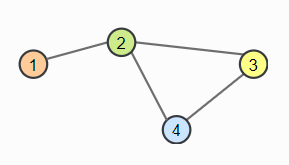

In [3]:
from IPython import display
display.Image("C:/Users/MRM/Desktop/Data_Analytics/Medium_and_PPB/Machine_Learning/Machine_Learning/Graph_Neural_Networks/Graph.png")

In [4]:
G = nx.Graph()

# Node colors in Hex code

blue, orange, green, yellow = "#1f77b4", "#ff7f0e", "#2ca02c","#FFFF00"

G.add_nodes_from([
    (1,{'color': orange}),
    (2,{'color': green}),
    (3,{'color': yellow}),
    (4,{'color': blue}),
])

G.add_edges_from([(1,2),(2,3),(2,4),(3,4)])

# Define Adjancent Matrix
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

def build_color_graph_node_matrix_X(G, mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in nx.get_node_attributes(G,'color').values()])
    one_hot_encoding = np.zeros((one_hot_idxs.size, len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size), one_hot_idxs] =1 
    
    return one_hot_encoding

X = build_color_graph_node_matrix_X(G, {green: 0, blue: 1, orange: 2, yellow: 3})

print(X)

[[0 1 0 0]
 [1 0 1 1]
 [0 1 0 1]
 [0 1 1 0]]
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


C:\Users\MRM\AppData\Local\Temp\ipykernel_21200\3425837505.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.asarray(nx.adjacency_matrix(G).todense())


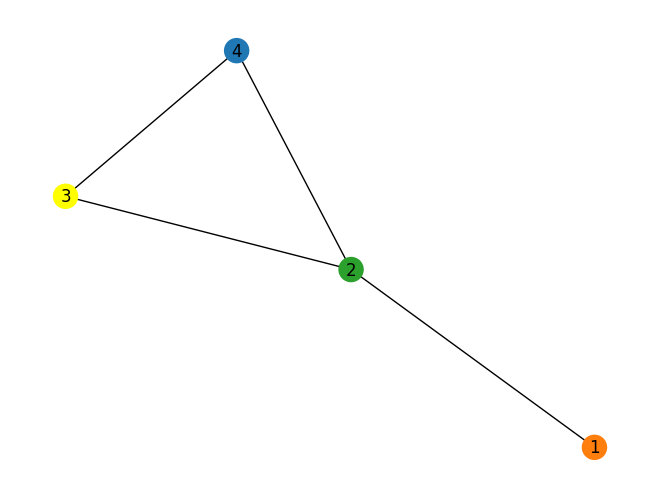

In [5]:
# Plot Graph
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw(G, with_labels = True, node_color = color_map)

## 2. Build a Graph with Deep Graph Library

DGL is compatible with Pytorch and Tensorflow

In [6]:
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=6) # 5 edges and 6 nodes
# Equivalently, PyTorch LongTensors also work.
g = dgl.graph((torch.LongTensor([0, 0, 0, 0, 0]), torch.LongTensor([1, 2, 3, 4, 5])), num_nodes=6)

# You can omit the number of nodes argument if you can tell the number of nodes from the edge list alone.
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))

# Print the source and destination nodes of every edge.
print(g.edges())

(tensor([0, 0, 0, 0, 0]), tensor([1, 2, 3, 4, 5]))


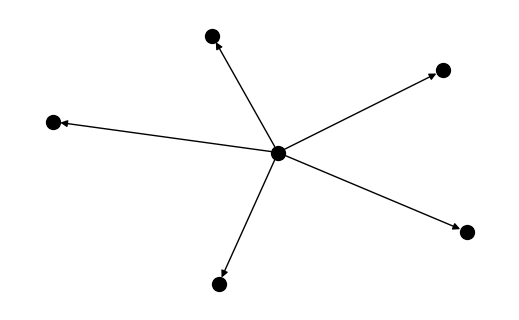

In [7]:
# Plot Graph by converting it to Networkx

options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[5,3])
nx.draw(G, **options)

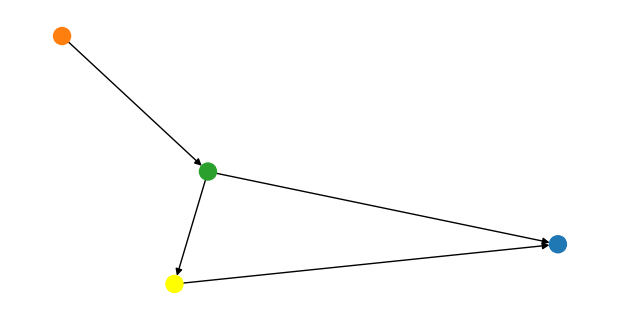

In [8]:
#([(1,2),(2,3),(2,4),(3,4)])
# Nodes count starts at zero
g1 = dgl.graph((torch.LongTensor([0, 1, 1, 2]), torch.LongTensor([1, 2, 3, 3])), num_nodes= 4)
color_dict = [orange, green, yellow, blue]


options = {
    'node_color':color_dict,
    'node_size': 150,
    'width': 1,
}
G1 = dgl.to_networkx(g1)
plt.figure(figsize=(6,3))
nx.draw(G1, **options)

In [ ]:
'''
Assigning Node and Edge Features to Graph

DGLGraph only accepts attributes stored in tensors (with numerical contents).
Consequently, an attribute of all the nodes or edges must have the same shape. 
In the context of deep learning, those attributes are often called features.

You can assign and retrieve node and edge features via ndata and edata interface.

'''

# Assign a 3-dimensional node feature vector for each node.
# First dimension is the number of nodes
g1.ndata['x'] = torch.randn(4, 3) 
# Assign a 4-dimensional edge feature vector for each edge.
# First dimension is the number of edges in the graph
g1.edata['a'] = torch.randn(4, 4)

print(g1.edata['a'])
print(g1.ndata['x'])
print(g1.num_nodes())
print(g1.num_edges())

In [ ]:
#Save graphs
dgl.save_graphs('graph.dgl', [g, g1])

# Load graphs
(g,g1), _ = dgl.load_graphs('graph.dgl')
print(g)
print(g1)

In [ ]:
print(g1.ndata['x'][0]) # Access to row 0 from 'x' feature

# 3. A GNN from scratch in Pytorch

In [31]:

class NodeNetwork(torch.nn.Module):
    # Code Graph Network operations
    def __init__(self, input_features):
        super().__init__()
        # Create layers
        self.conv_1 = BasicConvolutionLayer(input_features, 32) # This class will be created later
        self.conv_2 = BasicConvolutionLayer(32, 32)
        self.fc_1 = torch.nn.Linear(32,16)
        self.output_layer = torch.nn.Linear(16,2)
    
    def forward(self, X, A, batch_matrix):
        x1 = F.relu(self.conv_1(X, A))
        x2 = F.relu(self.conv_2(x1, A))
        # Pool Node Embeddings
        output = global_sum_pool(x2, batch_matrix) # Function added later
        output = self.fc_1(output)
        output = self.output_layer(output)
        # output membership class
        return F.softmax(output, dim = 1)

class BasicConvolutionLayer(torch.nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.input_channels = input_channels 
        self.output_channels = output_channels 
        # Weights and bias initalization
        
        self.W1 = Parameter(torch.rand((input_channels, output_channels), dtype = torch.float32))
        self.W2 = Parameter(torch.rand((input_channels, output_channels), dtype = torch.float32))
        self.bias = Parameter(torch.zeros(output_channels, dtype = torch.float32))
    
    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2) # torch.mm --> Tensor multiplication w.o. broadcasting
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.W1)
        
        output = root_update + propagated_msgs * self.bias 
        
        return output

In [19]:
print('X shape: ', X.shape)
print()
print('A shape', A.shape)

basicConvLayer = BasicConvolutionLayer(4,8)
out = basicConvLayer(
    X = torch.tensor(X, dtype = torch.float32), 
    A = torch.tensor(A, dtype = torch.float32)
    )

print('Output shape: ', out.shape)

# A four node graph with four features (four colors) is converted into a representation with 8 features

X shape:  (4, 4)

A shape (4, 4)
Output shape:  torch.Size([4, 8])


In [29]:
# Global Pooling can be done with any aggregation function, sum, max, mean here we add all implementations.
# Different papers suggest performance differences depending the function selected.

# batch_mat is a graph selection mask that keeps the graphs in the batch separete for varying size graphs.

def global_sum_pool( X, batch_mat):
    if batch_mat is None or batch_mat.dim == 1:
        return torch.sum(X, dim = 0).unsqueeze(0)
    else: 
        return torch.mm(batch_mat, X)
    
def global_max_pool( X, batch_mat):
    if batch_mat is None or batch_mat.dim == 1:
        return torch.max(X, dim = 0).unsqueeze(0)
    else: 
        return torch.mm(batch_mat, X)
    
def global_mean_pool( X, batch_mat):
    if batch_mat is None or batch_mat.dim == 1:
        return torch.mean(X, dim = 0).unsqueeze(0)
    else: 
        return torch.mm(batch_mat, X)

def get_batch_tensor(graph_sizes):
    starts = [sum(graph_sizes[:idx]) for idx, _ in enumerate(graph_sizes)]
    stops = [starts[idx] + graph_sizes[idx] for idx, _ in enumerate(graph_sizes)]
    
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)
    
    batch_mat = torch.zeros([batch_size, tot_len]).float()
    for idx, starts_and_stops in enumerate(zip(starts, stops)):
        start = starts_and_stops[0]
        stop = starts_and_stops[1]
        batch_mat[idx, start:stop] = 1
    return batch_mat

# batch is a list of dictionaries each containing
# the representation and label of a graph

def collate_graphs(batch):
    adj_mats = [graph['A'] for graph in batch]
    sizes = [A.size(0) for A in adj_mats]
    tot_size = sum(sizes)
    # create batch matrix
    batch_mat = get_batch_tensor(sizes)
    # combine feature matrices
    feat_mats = torch.cat([graph['X'] for graph in batch],dim=0)
    # combine labels
    labels = torch.cat([graph['y'] for graph in batch], dim=0)
    # combine adjacency matrices
    batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum:accum+g_size, accum:accum+g_size] = adj
        accum = accum + g_size
    repr_and_label = {
            'A': batch_adj, 
            'X': feat_mats,
            'y': labels,
            'batch' : batch_mat}

    return repr_and_label

PREPARING THE DATALOADER

In [23]:
def get_graph_dict(G, mapping_dict):
    ''' The function takes a NetworkX graph and returns a dictionary containing A, X and a binary label y'''
    # build dictionary representation of graph G
    A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()
    # build_graph_color_label_representation() was introduced with the first example graph
    X = torch.from_numpy(build_color_graph_node_matrix_X(G,mapping_dict)).float()
    # kludge since there is not specific task for this example
    y = torch.tensor([[1, 0]]).float()
    return {'A': A, 'X': X, 'y': y, 'batch': None}
    
# building 4 graphs to treat as a dataset

blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"
mapping_dict = {green: 0, blue: 1, orange: 2}

G1 = nx.Graph()
G1.add_nodes_from([(1, {"color": blue}),
                   (2, {"color": orange}),
                   (3, {"color": blue}),
                   (4, {"color": green})])
G1.add_edges_from([(1, 2), (2, 3),(1, 3), (3, 4)])
G2 = nx.Graph()
G2.add_nodes_from([(1, {"color": green}),
                   (2, {"color": green}),
                   (3, {"color": orange}),
                   (4, {"color": orange}),
                   (5,{"color": blue})])
G2.add_edges_from([(2, 3),(3, 4),(3, 1),(5, 1)])
G3 = nx.Graph()
G3.add_nodes_from([(1, {"color": orange}),
                   (2, {"color": orange}),
                   (3, {"color": green}),
                   (4, {"color": green}),
                   (5, {"color": blue}),
                   (6, {"color":orange})])
G3.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1), (2, 5), (6, 1)])
G4 = nx.Graph()
G4.add_nodes_from([(1, {"color": blue}), (2, {"color": blue}), (3, {"color": green})])
G4.add_edges_from([(1, 2), (2, 3)])
graph_list = [get_graph_dict(graph,mapping_dict) for graph in [G1, G2, G3, G4]]

C:\Users\MRM\AppData\Local\Temp\ipykernel_21200\171688820.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()


In [24]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class ExampleDataset(Dataset):
    
    # Simple PyTorch dataset that will use our list of graphs
    def __init__(self, graph_list):
        self.graphs = graph_list
        
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self,idx):
        mol_rep = self.graphs[idx]
        return mol_rep

In [27]:
dset = ExampleDataset(graph_list)
# Note how we use our custom collate function
loader = DataLoader(dset, batch_size=2, shuffle=False, collate_fn=collate_graphs)

In [32]:
torch.manual_seed(123)
node_features = 3
net = NodeNetwork(node_features)

# Predictions
batch_results = []

for b in loader:
    batch_results.append(net(b['X'], b['A'], b['batch']).detach())

G1_rep = dset[1]
G1_single = net(G1_rep['X'], G1_rep['A'], G1_rep['batch']).detach()

G1_batch = batch_results[0][1]
torch.all(torch.isclose(G1_single, G1_batch))

tensor(True)

# 4. Using PyTorch Geometric Library to create and train graphs

In [33]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool

In [34]:
# let's load the QM9 small molecule dataset
dset = QM9('.')
len(dset)

Extracting .\raw\qm9.zip
Processing...
100%|██████████| 133885/133885 [06:43<00:00, 331.49it/s]
Done!


130831

In [35]:
# Here's how torch geometric wraps data
data = dset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], name='gdb_1', idx=[1])

In [36]:
# can access attributes directly
data.z

tensor([6, 1, 1, 1, 1])

In [37]:
# the atomic number of each atom can add attributes
data.new_attribute = torch.tensor([1, 2, 3])
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], name='gdb_1', idx=[1], new_attribute=[3])

In [38]:
# can move all attributes between devices
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
    )
data.to(device)
data.new_attribute.is_cuda

False

In [39]:
# Implement a GNN and train it on QM9 to predict isotropic polarization.

# https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.NNConv

# Note:
# For edge_attributes adding
# nn (torch.nn.Module) – A neural network  that maps edge features edge_attr of 
# shape [-1, num_edge_features] to shape [-1, in_channels * out_channels], 
# e.g., defined by torch.nn.Sequential.

class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features):
        super().__init__()
        # Edge attributes creation of NN
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),
                                  nn.ReLU(),
                                  nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
        
    def forward(self, data):
        batch, x, edge_index, edge_attr=data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [40]:
'''  
train this GNN to predict a molecule’s isotropic polarizability, 
a measure of the relative tendency of a molecule’s
charge distribution to be distorted by an external electric field
'''

from torch.utils.data import random_split

train_set, valid_set, test_set = random_split(dset,[110000, 10831, 10000])

trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [41]:
qm9_node_feats, qm9_edge_feats = 11, 4
epochs = 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr="add", nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr="add", nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [42]:
for total_epochs in range(epochs):
    
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    
    
    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 0.39 | validation avg. loss: 0.22
Epochs: 1 | epoch avg. loss: 0.13 | validation avg. loss: 0.32
Epochs: 2 | epoch avg. loss: 0.11 | validation avg. loss: 0.06
Epochs: 3 | epoch avg. loss: 0.09 | validation avg. loss: 0.07


In [43]:
net.eval()
predictions = []
real = []

for batch in testloader:
    
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

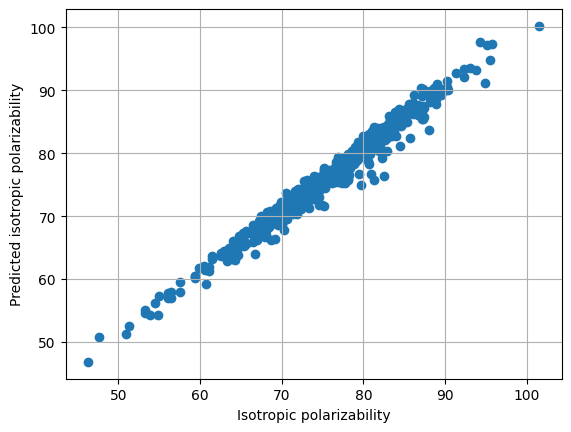

In [45]:
import matplotlib.pyplot as plt


plt.scatter(real[:500],predictions[:500])
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')
plt.grid(True)
#plt.savefig('figures/18_12.png', dpi=300)

# 5. Tensorflow and DGL Samples on Graph Applications

## 5.1 Node Classification

GNNs are the first class of techniques that can use both the node feature vectors and the connectivity information together to do node classification.

Essentially, the idea is to apply one or more graph convolutions to all nodes of a graph, to project the feature vector of the node to a corresponding output category vector that can be used to predict the node category.

## 5.2 Graph Classification

## 5.3 Edge Classification